# COMP551: Project 4

####Group 77:
#####Authors :  Boury Mbodj, Humayun Khan & Ying Sun 
#####Date : April 15 th 2019
#####Subject: The given file contains the implementation of the squeezenet1_0 for the use of the squeeze ratio experiment with squeeze ratio =0.125

In [0]:
import pandas as pd
import torch
import torchvision
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data import DataLoader, Dataset, TensorDataset

In [17]:
%%time
transform = transforms.Compose([transforms.Resize(32,32),
                               transforms.ToTensor(),
                               #transforms.Lambda(lambda x: x.repeat(3,1,1)),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
training_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
validation_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(training_dataset, batch_size=100, shuffle=True,num_workers=2)
validloader = torch.utils.data.DataLoader(validation_dataset, batch_size = 100, shuffle=False,num_workers=2)

Files already downloaded and verified
Files already downloaded and verified
CPU times: user 1.57 s, sys: 475 ms, total: 2.05 s
Wall time: 2.05 s


In [0]:
import math
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.utils.model_zoo as model_zoo


__all__ = ['SqueezeNet', 'squeezenet1_0', 'squeezenet1_1']


model_urls = {
    'squeezenet1_0': 'https://download.pytorch.org/models/squeezenet1_0-a815701f.pth',
   'squeezenet1_1': 'https://download.pytorch.org/models/squeezenet1_1-f364aa15.pth',
}

## esperimenting squeezeratio 0.125
class Fire(nn.Module):

    def __init__(self, inplanes, squeeze_planes,
                 expand1x1_planes, expand3x3_planes):
        super(Fire, self).__init__()
        self.inplanes = inplanes
        self.squeeze = nn.Conv2d(inplanes, squeeze_planes, kernel_size=1)
        self.squeeze_activation = nn.ReLU(inplace=True)
        self.expand1x1 = nn.Conv2d(squeeze_planes, expand1x1_planes,
                                   kernel_size=1)
        self.expand1x1_activation = nn.ReLU(inplace=True)
        self.expand3x3 = nn.Conv2d(squeeze_planes, expand3x3_planes,
                                   kernel_size=3, padding=1)
        self.expand3x3_activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.squeeze_activation(self.squeeze(x))
        return torch.cat([
            self.expand1x1_activation(self.expand1x1(x)),
            self.expand3x3_activation(self.expand3x3(x))
        ], 1)

# Imported class in order to perfrom directly squeezeratio experiments 
class SqueezeNet(nn.Module):

    def __init__(self, version=1.0, num_classes=1000):
        super(SqueezeNet, self).__init__()
        if version not in [1.0, 1.1]:
            raise ValueError("Unsupported SqueezeNet version {version}:"
                             "1.0 or 1.1 expected".format(version=version))
        self.num_classes = num_classes
        if version == 1.0:
            self.features = nn.Sequential(
                nn.Conv2d(3, 96, kernel_size=7, stride=2),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(96, 8, 64, 64),
                Fire(128, 8, 64, 64),
                Fire(128, 16, 128, 128),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(256, 16, 128, 128),
                Fire(256, 24, 192, 192),
                Fire(384, 24, 192, 192),
                Fire(384, 32, 256, 256),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(512, 32, 256, 256),
            )
        else:
            self.features = nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=3, stride=2),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(64, 16, 64, 64),
                Fire(128, 16, 64, 64),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(128, 32, 128, 128),
                Fire(256, 32, 128, 128),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(256, 48, 192, 192),
                Fire(384, 48, 192, 192),
                Fire(384, 64, 256, 256),
                Fire(512, 64, 256, 256),
            )
        # Final convolution is initialized differently form the rest
        final_conv = nn.Conv2d(512, self.num_classes, kernel_size=1)
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            final_conv,
            nn.ReLU(inplace=True),
            nn.AvgPool2d(13, stride=1)
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                if m is final_conv:
                    init.normal(m.weight.data, mean=0.0, std=0.01)
                else:
                    init.kaiming_uniform(m.weight.data)
                if m.bias is not None:
                    m.bias.data.zero_()

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x.view(x.size(0), self.num_classes)


def squeezenet1_0(pretrained=False, **kwargs):
    r"""SqueezeNet model architecture from the `"SqueezeNet: AlexNet-level
    accuracy with 50x fewer parameters and <0.5MB model size"
    <https://arxiv.org/abs/1602.07360>`_ paper.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = SqueezeNet(version=1.0, **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['squeezenet1_0']))
    return model



def squeezenet1_1(pretrained=False, **kwargs):
    r"""SqueezeNet 1.1 model from the `official SqueezeNet repo
    <https://github.com/DeepScale/SqueezeNet/tree/master/SqueezeNet_v1.1>`_.
    SqueezeNet 1.1 has 2.4x less computation and slightly fewer parameters
    than SqueezeNet 1.0, without sacrificing accuracy.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = SqueezeNet(version=1.1, **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['squeezenet1_1']))
    return model

In [19]:
model= squeezenet1_0(pretrained=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:94: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:92: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.


In [20]:
# Add code to get model size and number of parameters
import pickle
import sys

p = pickle.dumps(model)

size = sys.getsizeof(p)  #gets the size in bytes
size = size/1000000
print("Model size =", size, "MBs")



def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp
  
print("Total number of parameters before reducing class size: ")
print(get_n_params(model))

from torch.nn.modules.module import _addindent
def torch_summarize(model, show_weights=True, show_parameters=True):
    """Summarizes torch model by showing trainable parameters and weights."""
    tmpstr = model.__class__.__name__ + ' (\n'
    for key, module in model._modules.items():
        # if it contains layers let call it recursively to get params and weights
        if type(module) in [
            torch.nn.modules.container.Container,
            torch.nn.modules.container.Sequential
        ]:
            modstr = torch_summarize(module)
        else:
            modstr = module.__repr__()
        modstr = _addindent(modstr, 2)

        params = sum([np.prod(p.size()) for p in module.parameters()])
        weights = tuple([tuple(p.size()) for p in module.parameters()])

        tmpstr += '  (' + key + '): ' + modstr 
        if show_weights:
            tmpstr += ', weights={}'.format(weights)
        if show_parameters:
            tmpstr +=  ', parameters={}'.format(params)
        tmpstr += '\n'   

    tmpstr = tmpstr + ')'
    return tmpstr
  
print(torch_summarize(model))

Model size = 3.585569 MBs
Total number of parameters before reducing class size: 
889096
SqueezeNet (
  (features): Sequential (
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2)), weights=((96, 3, 7, 7), (96,)), parameters=14208
    (1): ReLU(inplace), weights=(), parameters=0
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True), weights=(), parameters=0
    (3): Fire(
      (squeeze): Conv2d(96, 8, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace)
      (expand1x1): Conv2d(8, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace)
      (expand3x3): Conv2d(8, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace)
    ), weights=((8, 96, 1, 1), (8,), (64, 8, 1, 1), (64,), (64, 8, 3, 3), (64,)), parameters=6024
    (4): Fire(
      (squeeze): Conv2d(128, 8, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace)
      (expand1x1): C

In [21]:
print(model)

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 8, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace)
      (expand1x1): Conv2d(8, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace)
      (expand3x3): Conv2d(8, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 8, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace)
      (expand1x1): Conv2d(8, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace)
      (expand3x3): Conv2d(8, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace)
    )
    (5): Fire(
      (squeeze): Conv2d(128, 16, kernel_size

In [0]:
# Adapt the classifier to our actual computatioons 
classifier = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Conv2d(512, 10, kernel_size=1),
    nn.ReLU(inplace=True),
    nn.AvgPool2d(1)
)
model.classifier= classifier
model.forward = lambda x: model.classifier(model.features(x)).view(x.size(0), 10)


In [23]:
print("Total number of parameters after reducing class size: ")
print(get_n_params(model))

print(torch_summarize(model))

Total number of parameters after reducing class size: 
381226
SqueezeNet (
  (features): Sequential (
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2)), weights=((96, 3, 7, 7), (96,)), parameters=14208
    (1): ReLU(inplace), weights=(), parameters=0
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True), weights=(), parameters=0
    (3): Fire(
      (squeeze): Conv2d(96, 8, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace)
      (expand1x1): Conv2d(8, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace)
      (expand3x3): Conv2d(8, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace)
    ), weights=((8, 96, 1, 1), (8,), (64, 8, 1, 1), (64,), (64, 8, 3, 3), (64,)), parameters=6024
    (4): Fire(
      (squeeze): Conv2d(128, 8, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace)
      (expand1x1): Conv2d(8, 64, kernel_size=(1

In [24]:
print (model)

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 8, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace)
      (expand1x1): Conv2d(8, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace)
      (expand3x3): Conv2d(8, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 8, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace)
      (expand1x1): Conv2d(8, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace)
      (expand3x3): Conv2d(8, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace)
    )
    (5): Fire(
      (squeeze): Conv2d(128, 16, kernel_size

In [0]:
#import optimizer:
from torch import optim
#define criteria and optimizer
# Note that other losses or optimizers can also be tried
criteria = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=0.004, amsgrad=True)
optimizer = optim.SGD(model.parameters(), lr = 0.0004, momentum=0.9)

In [0]:
#train model
#define training function
def train (model, loader, criterion, gpu):
    model.train()
    current_loss = 0
    current_correct = 0
    current_correct_5=0
    for train, y_train in iter(loader):
        if gpu:
            train, y_train = train.to('cuda'), y_train.to('cuda')
        optimizer.zero_grad()
        output = model.forward(train)
        _, preds = torch.max(output,1)#The most likelihood
        _, preds_5=torch.topk(output, 5, largest=True, sorted=True)#Top-5 prediction
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()
        current_loss += loss.item()*train.size(0)
        current_correct += torch.sum(preds == y_train.data)
        for i in range(100):
            for j in preds_5[i]:
                current_correct_5+=torch.sum(y_train.data[i]==j)
        #print(output,preds,preds_5)
        #check if the training is correct: 
        #print(preds,y_train,current_correct,current_loss)
    epoch_loss = current_loss / len(loader)
    # devide 4 because we read 4 data everytime
    epoch_acc = current_correct.double() / len(loader)/100 # Top 1 accuracy
    epoch_acc_5 = current_correct_5.double()/len(loader)/100 #Top 5 accuracy
        
    return epoch_loss, epoch_acc,epoch_acc_5

In [0]:
#define validation function
def validation (model, loader, criterion, gpu):
    model.eval()
    valid_loss = 0
    valid_correct = 0
    valid_correct_5 = 0 #Top 5 accuracy
    #I added this
    pred=torch.zeros(len(loader))
    for valid, y_valid in iter(loader):
        if gpu:
            valid, y_valid = valid.to('cuda'), y_valid.to('cuda')
        output = model.forward(valid)
        _, preds = torch.max(output,1)
        _, preds_5=torch.topk(output, 5, largest=True, sorted=True)
        valid_loss += criterion(output, y_valid).item()*valid.size(0)
        valid_correct += torch.sum(preds == y_valid.data)
        for i in range(100):
            for j in preds_5[i]:
                valid_correct_5+=torch.sum(y_valid.data[i]==j)
    epoch_loss = valid_loss / len(loader)
    epoch_acc = valid_correct.double() / len(loader)/100
    epoch_acc_5 = valid_correct_5.double() / len(loader)/100
    
    return epoch_loss, epoch_acc,epoch_acc_5

In [0]:
#define test function
def test (model, loader, criterion, gpu):
    model.eval()
    valid_loss = 0
    valid_correct = 0
    i=0
    pred=torch.zeros(len(loader))
    for test, y_train in iter(loader):
        if gpu:
            test = test.to('cuda')
        output = model.forward(test)
        _, preds = torch.max(output,1)
        pred[i]=preds
        i=i+1    
    return pred

In [29]:
# training
#send model to gpu. If not send it to GPU, delete next line.
model.to('cuda')
train_losses =[]
train_acc =[]
train_acc_5 =[]
valid_losses=[]
valid_acc =[]
valid_acc_5 =[]
#Initialize training params  
#freeze gradient parameters in pretrained model
for param in model.parameters():
    param.require_grad = True
# define number of epochs
epochs = 15 
epoch = 0
import time
start=time.time()
for e in range(epochs):
    start_train = time.time()
    epoch +=1
    print(epoch)
#train:    
    with torch.set_grad_enabled(True):
        epoch_train_loss, epoch_train_acc, epoch_train_acc_5 = train(model,trainloader, criteria, 1)
        #epoch_train_acc = train(model,trainloader, criteria, 1)
        train_losses.append(epoch_train_loss)
        train_acc.append(epoch_train_acc)
        train_acc_5.append(epoch_train_acc_5)
    print("Epoch: {} Train Loss : {:.4f}  Top1 Accuracy: {:.4f}  Top5 Accuracy: {:.4f}".format(epoch,epoch_train_loss,epoch_train_acc,epoch_train_acc_5))
    end_train=time.time()
#Valid, Activate next code when validation result is needed:
    with torch.no_grad():
        epoch_val_loss, epoch_val_acc,epoch_val_acc_5 = validation(model, validloader, criteria, 1)
        valid_losses.append(epoch_val_loss)
        valid_acc.append(epoch_val_acc)
        valid_acc_5.append(epoch_val_acc_5)
    print("Epoch: {} Validation Loss : {:.4f}  Top 1 Validation Accuracy {:.4f} Top5 Validation Accuracy: {:.4f}".format(epoch,epoch_val_loss,epoch_val_acc,epoch_val_acc_5))
    end_valid = time.time()
    print("Training time for Epoch {}: {:.4f}s".format(epoch,end_train-start_train))
    print("Validation time for Epoch {}: {:.4f}s".format(epoch,end_valid-end_train))
end=time.time()
print("Total time for training and validation: {:.4f}s".format(end-start))

1
Epoch: 1 Train Loss : 225.7510  Top1 Accuracy: 0.1463  Top5 Accuracy: 0.5739
Epoch: 1 Validation Loss : 211.0234  Top 1 Validation Accuracy 0.2336 Top5 Validation Accuracy: 0.7366
Training time for Epoch 1: 37.0991s
Validation time for Epoch 1: 6.2448s
2
Epoch: 2 Train Loss : 200.6847  Top1 Accuracy: 0.2548  Top5 Accuracy: 0.7862
Epoch: 2 Validation Loss : 185.2288  Top 1 Validation Accuracy 0.3040 Top5 Validation Accuracy: 0.8418
Training time for Epoch 2: 37.0920s
Validation time for Epoch 2: 6.2306s
3
Epoch: 3 Train Loss : 184.9716  Top1 Accuracy: 0.3080  Top5 Accuracy: 0.8430
Epoch: 3 Validation Loss : 175.2285  Top 1 Validation Accuracy 0.3454 Top5 Validation Accuracy: 0.8697
Training time for Epoch 3: 36.9042s
Validation time for Epoch 3: 6.2480s
4
Epoch: 4 Train Loss : 176.1619  Top1 Accuracy: 0.3386  Top5 Accuracy: 0.8698
Epoch: 4 Validation Loss : 169.1164  Top 1 Validation Accuracy 0.3677 Top5 Validation Accuracy: 0.8845
Training time for Epoch 4: 37.0921s
Validation time f

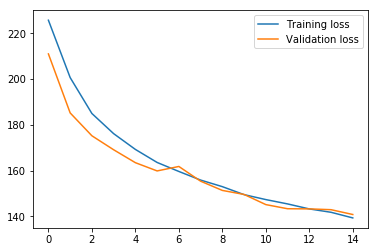

In [30]:
#Plot training and validation losses
import matplotlib.pyplot as plt
import numpy as np
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend()

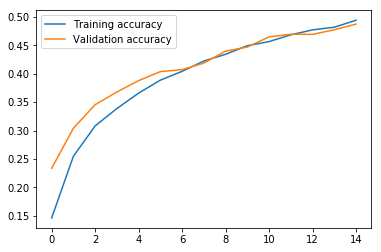

In [31]:
#Plot training and validation accuracy
plt.plot(train_acc, label='Training accuracy')
plt.plot(valid_acc, label='Validation accuracy')
plt.legend()

In [32]:
# for variety, lets use altair to do the plot
import altair as alt

# create a pandas dataframe for the loss
df = pd.DataFrame({
    'epoch': range(1, len(train_losses) + 1),
    'train': train_losses,
    'valid': valid_losses
})

# unpivot to have cols [epoch, dataset, loss]
df = df.melt(id_vars=['epoch'],
             value_vars=['train', 'valid'],
             value_name='loss',
             var_name='Dataset')

# line plot with altair
alt.Chart(df).mark_line(point=True)\
    .encode(x='epoch', y='loss', color='Dataset')\
    .interactive()

Chart({
  data:     epoch Dataset        loss
  0       1   train  225.750950
  1       2   train  200.684719
  2       3   train  184.971612
  3       4   train  176.161877
  4       5   train  169.265586
  5       6   train  163.566979
  6       7   train  159.626604
  7       8   train  155.864117
  8       9   train  152.986836
  9      10   train  149.492747
  10     11   train  147.331480
  11     12   train  145.434555
  12     13   train  143.244174
  13     14   train  141.775259
  14     15   train  139.313715
  15      1   valid  211.023387
  16      2   valid  185.228826
  17      3   valid  175.228490
  18      4   valid  169.116374
  19      5   valid  163.465999
  20      6   valid  159.859309
  21      7   valid  161.811458
  22      8   valid  155.378484
  23      9   valid  151.337004
  24     10   valid  149.575054
  25     11   valid  145.137363
  26     12   valid  143.325713
  27     13   valid  143.260269
  28     14   valid  142.913405
  29     15   valid  140.804837,
  encoding: EncodingWithFacet({
    color: Color({
      shorthand: 'Dataset'
    }),
    x: X({
      shorthand: 'epoch'
    }),
    y: Y({
      shorthand: 'loss'
    })
  }),
  mark: MarkDef({
    point: True,
    type: 'line'
  }),
  selection: SelectionMapping({
    selector001: SelectionDef({
      bind: 'scales',
      encodings: ['x', 'y'],
      type: 'interval'
    })
  })
})